In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from Loader import Loader
import Constants as C
from Cuts import qlayerCut, maxDistMaxDoms, balloonCut

In [2]:
# Load the 2014 burn sample
basesel = C.basesel
basesel += '&&(ImpLF_rchi2>80&&tlarge5[0]-tearly5[0] < 200)'

load = Loader(basesel)
dt2014 = load.load(fname=C.BS2014)
dt2013 = load.getData()

In [3]:
# Add weights
dt2014['w'] = pd.Series(np.ones(len(dt2014),dtype=float),index=dt2014.index)
dt2013['w'] = pd.Series(np.ones(len(dt2013),dtype=float),index=dt2013.index)

dt2014['w'] = dt2014['w']/sum(dt2014['w'])
dt2013['w'] = dt2013['w']/sum(dt2013['w'])

# Add max dist
dt2014['maxDist'] = maxDistMaxDoms(dt2014)
dt2013['maxDist'] = maxDistMaxDoms(dt2013)



In [4]:
# Place L3 cuts
def L3(dt):
    dt = qlayerCut(dt,False,0.8)
    dt = balloonCut(dt)
    return dt

dt2014 = L3(dt2014)
dt2013 = L3(dt2013)
    

In [5]:
# Setup the info
info = {'data' : [dt2013, dt2014],
        'names'  : ['BS 2012-2013', 'BS 2013-2014'],
        'colors'  : ['r','b'],
        'weights'    : ['w','w'],
        'ls'   : ['solid','dashed'],
        'lw' : [1.5,1.5],
        'marker' : [' ',' ']
       }


In [6]:
variables = {'hs_z_travel' : [50,-500,500, 'ztravel','z-travel [m]'],
             'log10(hs_q_tot_pulses)' : [40, 3, 7, 'logqtot','log10(NPE)'],
             'cumuAt600ns' : [25,0,1,'cumuAt600ns','Cumulative @ 600ns'],
             'maxDist' : [25,0,1000,'maxDist','Max Dist 3 Largest Charge DOms'],
             'ImpLF_rchi2' : [50,0,500,'rchi2',r'Reduced $\chi^{2}$'],
             'hs_cogz' : [50,-500,500,'cog_z','COG z [m]'],
             'sqrt(hs_cogx*hs_cogx+hs_cogy*hs_cogy)' : [30,0,600,'cog_rho',r'COG $\rho$'],
             'rho_travel5' : [50,0,1000,'rhotravel5pe',r'$\rho$-travel (> 5 p.e.) [m]'],
             'ndoms_5pe' : [50,0,500,'hitdoms5pe','N Hit Doms (> 5 p.e.)'],
             'nstr_2ndway_5pe' : [60,0,60,'nstr_2ndway_5pe','N Hit Strings (> 5 p.e.)']
            }

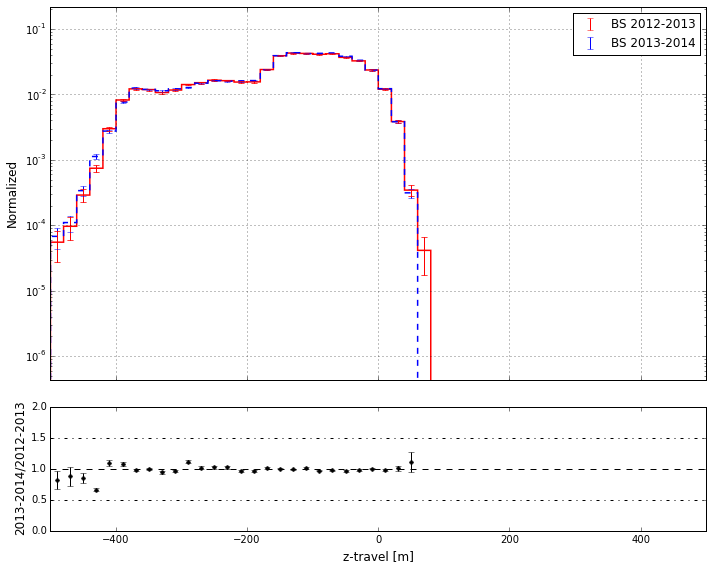

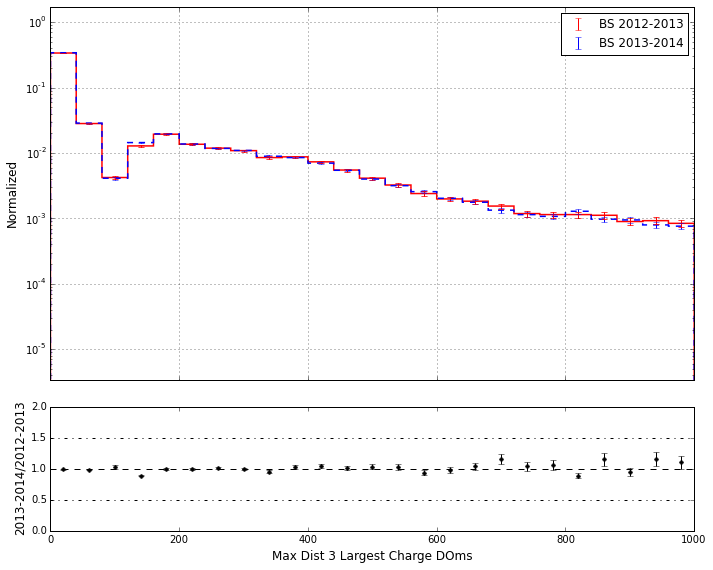

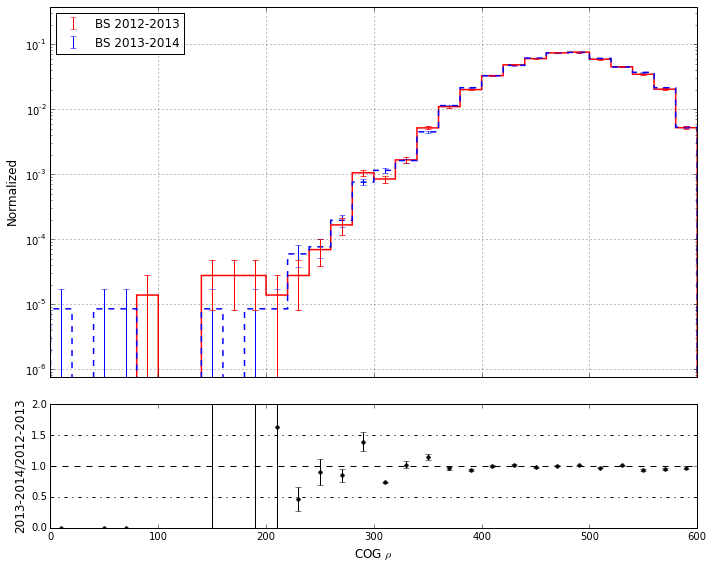

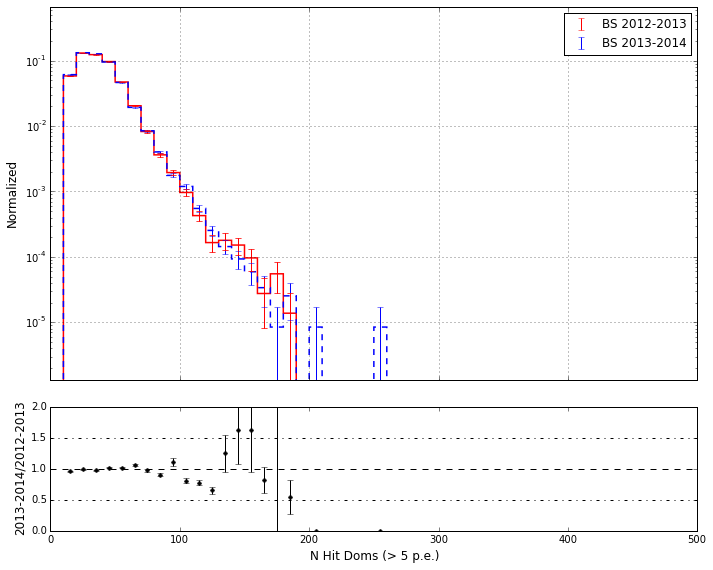

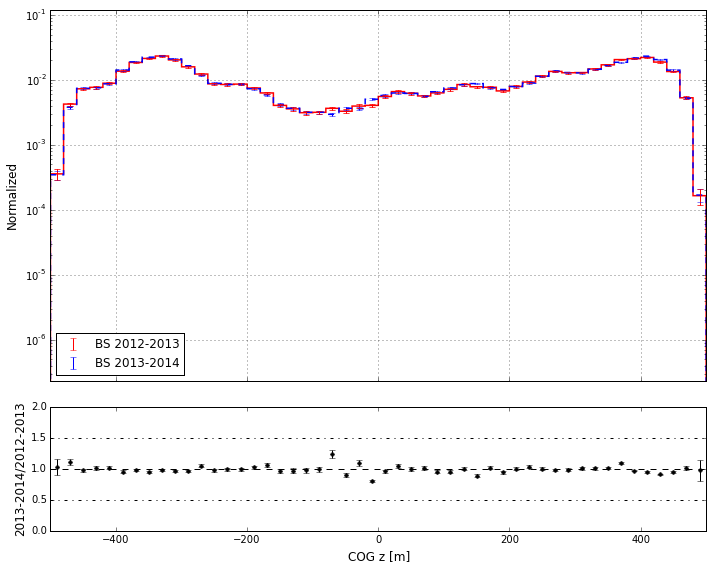

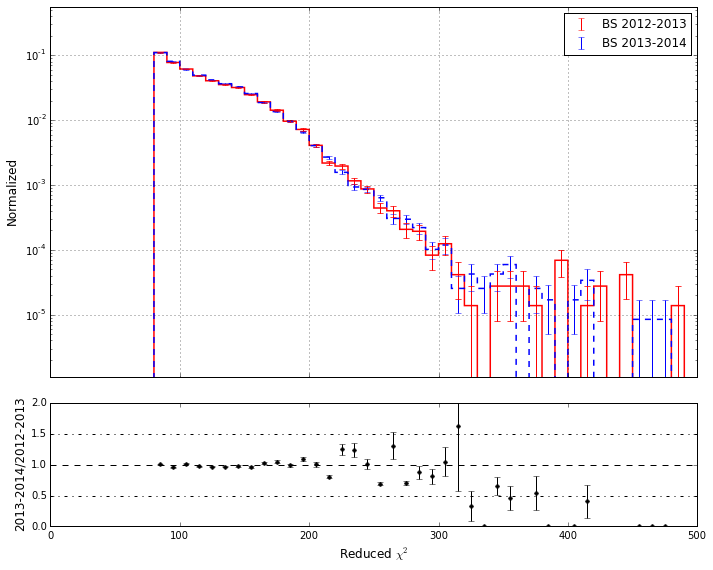

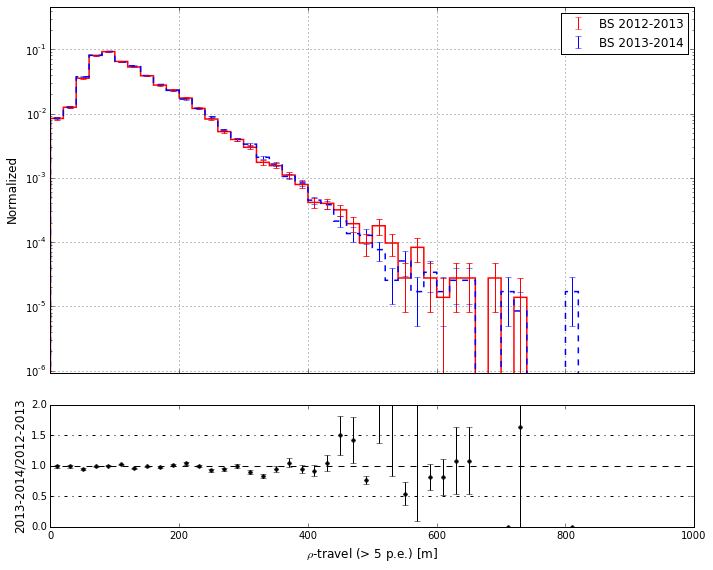

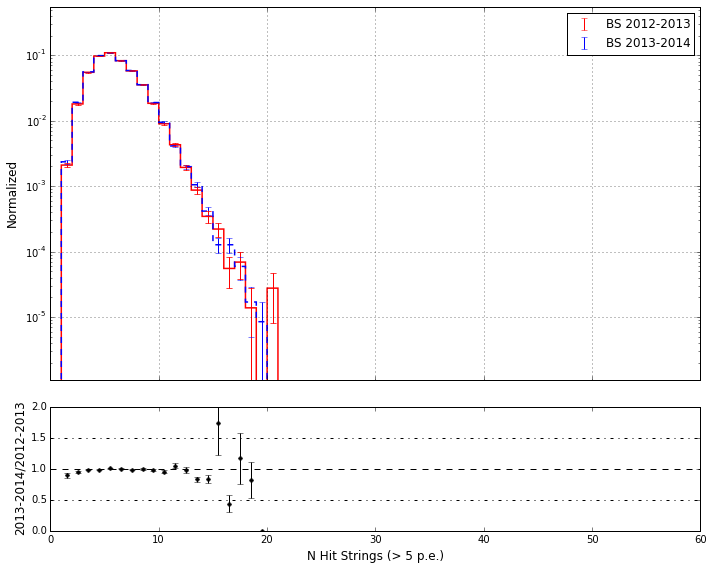

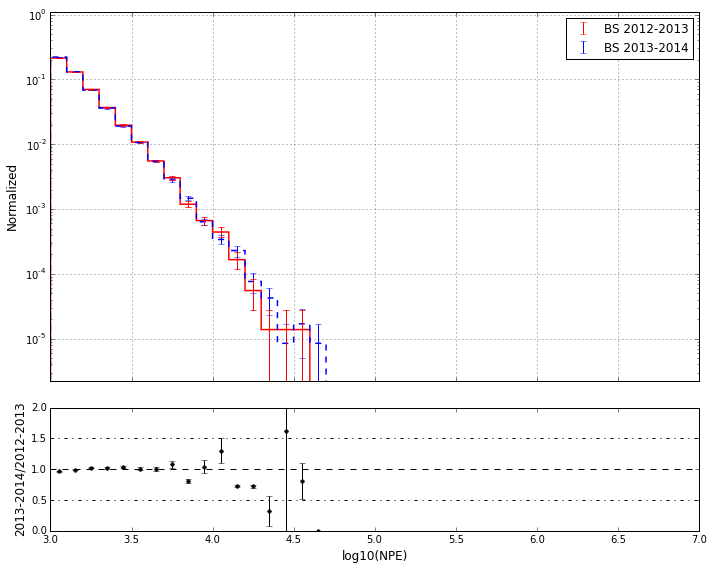

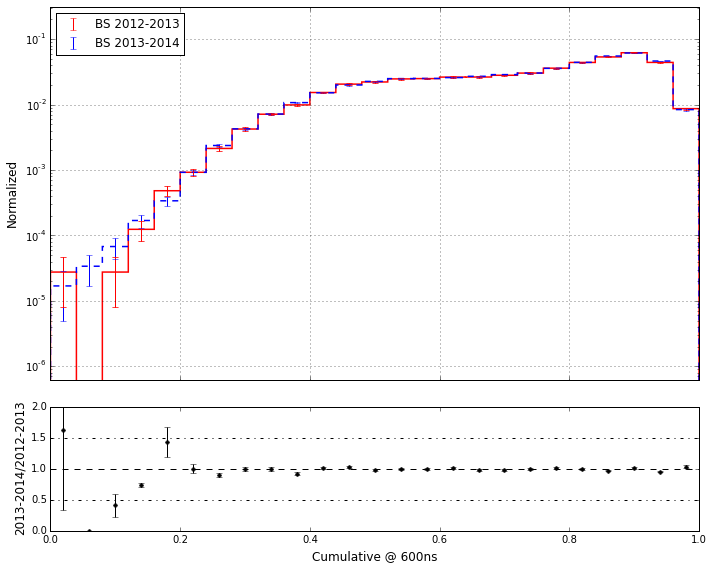

In [7]:
# Plot dat shit
from PlotTool import PlotTool
p_tool = PlotTool()

import matplotlib.pyplot as plt

for var in variables:
    lims = variables[var]
    p_tool.plotStackedRatio(info, 
                            var, 
                            lims[4],
                            lims[0], lims[1], lims[2], 
                            1e-5,
                            True, False,False,
                            "",
                            "2013-2014/2012-2013",
                            "Normalized")
    
    plt.savefig('../plots/bs2013_2014comp/'+lims[3]+'.png')

In [8]:
# Load the classifier
from sklearn.externals import joblib
clf = joblib.load('../models/bdt_hyperparamopt_cleaningupdate.pkl')

In [10]:
# We only want to use the data from 2012-2013 that was NOT
# used in the training, so pull that off:
from sklearn.cross_validation import train_test_split

trainfrac = 0.5
dttargets = pd.Series(np.ones(len(dt2013),dtype=int),index=dt2013.index)
X_train, X_test, y_train, y_test = train_test_split(dt2013,
                                                    dttargets,
                                                    train_size=trainfrac,
                                                    random_state=194637)
X_test['w'] = X_test['w']/(1-trainfrac)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
X_test['scores'] = pd.Series(clf.decision_function(X_test[C.bdt_features]),index=X_test.index)
dt2014['scores'] = pd.Series(clf.decision_function(dt2014[C.bdt_features]),index=dt2014.index)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
# Setup the info
info = {'data' : [X_test, dt2014],
        'names'  : ['BS 2012-2013 (50%)', 'BS 2013-2014'],
        'colors'  : ['r','b'],
        'weights'    : ['w','w'],
        'ls'   : ['solid','dashed'],
        'lw' : [1.5,1.5],
        'marker' : [' ',' ']
       }

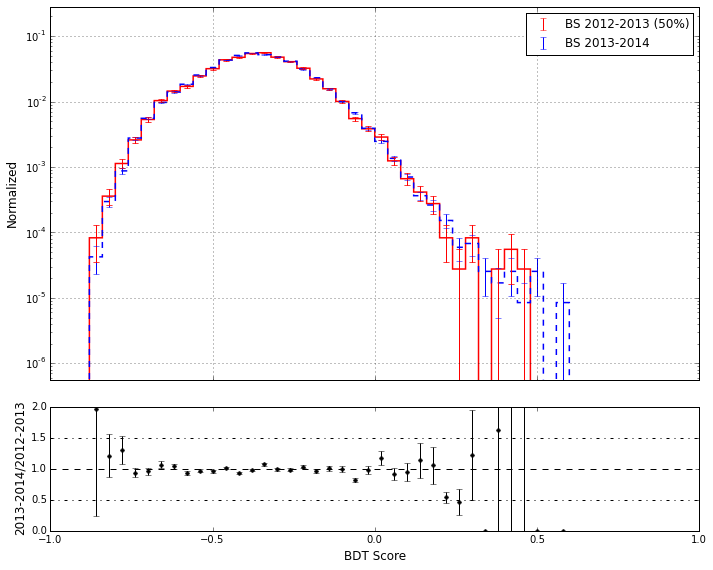

In [15]:
p_tool.plotStackedRatio(info, 'scores', 'BDT Score', 50, -1, 1, 1e-5,
                        True, False, False, "",
                        "2013-2014/2012-2013",
                        "Normalized")
plt.savefig('../plots/bs2013_2014comp/bdtscore_comp.png')
